In [1]:
import os
from pathlib import Path
import torch, numpy as np, pandas as pd
import numpy as np
from torch import tensor
from fastai.data.transforms import RandomSplitter
import sympy
import torch.nn.functional as F
from fastai.tabular.all import *
from fastai.imports import *
import seaborn as sns
from numpy import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from ipywidgets import interact
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

In [153]:
#!pip install sympy
#!pip install seaborn
!pip install graphviz

Defaulting to user installation because normal site-packages is not writeable


In [2]:
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path('../input/titanic')
else:
    path = Path('titanic')
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████| 34.1k/34.1k [00:00<00:00, 7.92MB/s]

In [4]:
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

In [5]:
df = pd.read_csv(path/'train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [6]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [8]:
df.fillna(modes, inplace=True)

In [9]:
df.isna().sum()
#We have imputed the missing values

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [11]:
df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


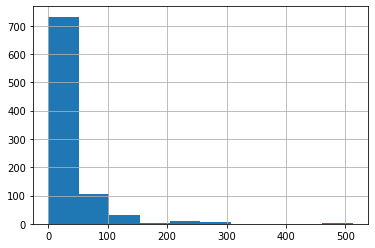

In [12]:
df['Fare'].hist();

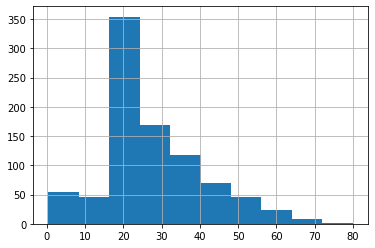

In [13]:
df['Age'].hist();

In [14]:
df['LogFare'] = np.log(df['Fare']+1)

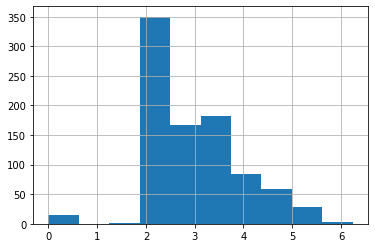

In [15]:
df['LogFare'].hist();

In [17]:
df['LogAge'] = np.log(df['Age']+1)

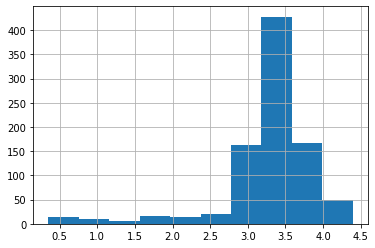

In [18]:
df['LogAge'].hist();

In [19]:
pclasses = sorted(df.Pclass.unique())
pclasses

[1, 2, 3]

In [20]:
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


In [21]:
df = pd.get_dummies(df, columns=["Sex","Pclass","Embarked"])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'LogA', 'LogAge', 'Sex_female',
       'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [22]:
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_cols].head()

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,0,0,1,0,0,1
1,0,1,1,0,0,1,0,0
2,0,1,0,0,1,0,0,1
3,0,1,1,0,0,0,0,1
4,1,0,0,0,1,0,0,1


In [24]:
t_dep = tensor(df.Survived)

In [25]:
indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols

t_indep = tensor(df[indep_cols].values, dtype=torch.float)
t_indep

tensor([[22.0000,  1.0000,  0.0000,  2.1102,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  0.0000,  2.1889,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  0.0000,  3.9908,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  0.0000,  0.0000,  2.2028,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [24.0000,  0.0000,  0.0000,  2.2469,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [54.0000,  0.0000,  0.0000,  3.9677,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        ...,
        [25.0000,  0.0000,  0.0000,  2.0857,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [39.0000,  0.0000,  5.0000,  3.4054

In [26]:
t_indep.shape

torch.Size([891, 12])

# Make a linear model

In [27]:
torch.manual_seed(442)

n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff)-0.5
coeffs

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625])

In [28]:
t_indep*coeffs

tensor([[-10.1838,   0.1386,   0.0000,  -0.4772,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-17.5902,   0.1386,   0.0000,  -0.9681,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.4392,   0.0000,   0.0000],
        [-12.0354,   0.0000,   0.0000,  -0.4950,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.1386,   0.0000,  -0.9025,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.0000,   0.0000,  -0.4982,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-11.1096,   0.0000,   0.0000,  -0.5081,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.2103,   0.0000],
        [-24.9966,   0.0000,   0.0000,  -0.8973,  -0.2632,  -0.0000,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        ...,
        [-11.5725,   0.0000,   0.0000,  -0.4717,  -0.2632,  -0.0000,   0.0000

In [29]:
#normalizing
vals,indices = t_indep.max(dim=0)
t_indep = t_indep / vals

In [30]:
t_indep*coeffs

tensor([[-0.1273,  0.0173,  0.0000, -0.0765, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2199,  0.0173,  0.0000, -0.1551, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.4392,  0.0000,  0.0000],
        [-0.1504,  0.0000,  0.0000, -0.0793, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0173,  0.0000, -0.1446, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0000,  0.0000, -0.0798, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.1389,  0.0000,  0.0000, -0.0814, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.2103,  0.0000],
        [-0.3125,  0.0000,  0.0000, -0.1438, -0.2632, -0.0000,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        ...,
        [-0.1447,  0.0000,  0.0000, -0.0756, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2257,  0.0000,  0.2008, -0.1234

In [31]:
t_indep = t_indep / vals

In [32]:
preds = (t_indep*coeffs).sum(axis=1)

In [33]:
preds[:5]


tensor([ 0.3675, -0.2917,  0.3131,  0.5119,  0.3638])

In [34]:
loss = torch.abs(preds-t_dep).mean()
loss

tensor(0.5415)

In [35]:
def calc_preds(coeffs, indeps): return (indeps*coeffs).sum(axis=1)
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

In [36]:
coeffs.requires_grad_()

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625], requires_grad=True)

In [37]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss

tensor(0.5415, grad_fn=<MeanBackward0>)

In [38]:
loss.backward()

In [39]:
coeffs.grad

tensor([ 0.0003,  0.0018, -0.0005, -0.0034,  0.2548, -0.1908, -0.1212, -0.0067,  0.1919, -0.1886,  0.0191,  0.2334])

In [40]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
coeffs.grad

tensor([ 0.0007,  0.0036, -0.0010, -0.0069,  0.5095, -0.3816, -0.2424, -0.0135,  0.3838, -0.3771,  0.0382,  0.4669])

In [41]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
with torch.no_grad():
    coeffs.sub_(coeffs.grad * 0.1)
    coeffs.grad.zero_()
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.4685)


# Train this linear model

In [43]:
trn_split,val_split=RandomSplitter(seed=42)(df)

In [44]:
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]
len(trn_indep),len(val_indep)

(713, 178)

In [45]:
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

In [46]:
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

In [47]:
def init_coeffs(): return (torch.rand(n_coeff)-0.5).requires_grad_()

In [81]:
def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs): one_epoch(coeffs, lr=lr)
    return coeffs

In [49]:
coeffs = train_model(18, lr=0.2)

0.539; 0.492; 0.444; 0.419; 0.426; 0.379; 0.386; 0.367; 0.340; 0.358; 0.311; 0.354; 0.329; 0.301; 0.323; 0.283; 0.304; 0.285; 

In [50]:
def show_coeffs(): return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs()

{'Age': tensor(-0.4620),
 'SibSp': tensor(0.1377),
 'Parch': tensor(0.2451),
 'LogFare': tensor(-0.1862),
 'Sex_male': tensor(-0.4198),
 'Sex_female': tensor(0.2177),
 'Pclass_1': tensor(0.6980),
 'Pclass_2': tensor(0.3781),
 'Pclass_3': tensor(0.3809),
 'Embarked_C': tensor(0.0702),
 'Embarked_Q': tensor(0.2114),
 'Embarked_S': tensor(0.2279)}

In [51]:
preds = calc_preds(coeffs, val_indep)

In [52]:
results = val_dep.bool()==(preds>0.5)
results[:16]

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False, False, False,  True,  True, False])

In [53]:
results.float().mean()

tensor(0.7865)

In [54]:
def acc(coeffs): return (val_dep.bool()==(calc_preds(coeffs, val_indep)>0.5)).float().mean()
acc(coeffs)

tensor(0.7865)

In [55]:
preds[:28]

tensor([0.7931, 0.1604, 0.0195, 0.1643, 0.1718, 0.1711, 0.6625, 0.8090, 0.1948, 0.6609, 0.1762, 0.0252, 0.1857, 0.7978, 0.1769, 0.4870,
        0.4855, 0.8129, 0.1676, 0.8133, 0.1768, 0.4862, 0.9695, 0.8159, 0.1776, 0.1575, 0.8234, 0.4858])

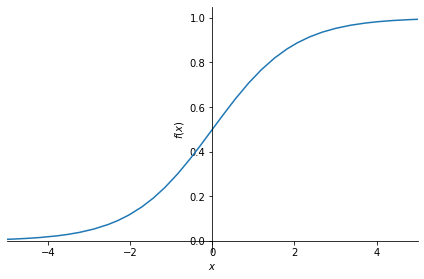

In [59]:
sympy.plot("1/(1+exp(-x))", xlim=(-5,5));

In [60]:
def calc_preds(coeffs, indeps): return torch.sigmoid((indeps*coeffs).sum(axis=1))

In [61]:
coeffs = train_model(lr=100)

0.524; 0.291; 0.211; 0.203; 0.199; 0.198; 0.198; 0.197; 0.197; 0.196; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 

In [62]:
acc(coeffs)

tensor(0.8258)

In [63]:
show_coeffs()

{'Age': tensor(-0.4786),
 'SibSp': tensor(-0.0450),
 'Parch': tensor(0.1119),
 'LogFare': tensor(-0.2008),
 'Sex_male': tensor(-10.1734),
 'Sex_female': tensor(7.9806),
 'Pclass_1': tensor(3.3944),
 'Pclass_2': tensor(2.2695),
 'Pclass_3': tensor(-6.1976),
 'Embarked_C': tensor(1.4253),
 'Embarked_Q': tensor(2.1883),
 'Embarked_S': tensor(-5.0948)}

# Create a neural network

In [64]:
def init_coeffs(n_hidden=20):
    layer1 = (torch.rand(n_coeff, n_hidden)-0.5)/n_hidden
    layer2 = torch.rand(n_hidden, 1)-0.3
    const = torch.rand(1)[0]
    return layer1.requires_grad_(),layer2.requires_grad_(),const.requires_grad_()

In [66]:
def calc_preds(coeffs, indeps):
    l1,l2,const = coeffs
    res = F.relu(indeps@l1)
    res = res@l2 + const
    return torch.sigmoid(res)

In [67]:
def update_coeffs(coeffs, lr):
    for layer in coeffs:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

In [82]:
coeffs = train_model(lr=1.4)

0.544; 0.538; 0.533; 0.527; 0.521; 0.514; 0.507; 0.499; 0.491; 0.483; 0.474; 0.465; 0.456; 0.447; 0.439; 0.431; 0.424; 0.418; 0.413; 0.409; 0.405; 0.402; 0.399; 0.397; 0.395; 0.394; 0.392; 0.391; 0.390; 0.389; 

In [83]:
coeffs = train_model(lr=0.1)

0.544; 0.544; 0.543; 0.543; 0.542; 0.542; 0.541; 0.541; 0.540; 0.540; 0.540; 0.539; 0.539; 0.538; 0.538; 0.537; 0.537; 0.537; 0.536; 0.536; 0.535; 0.535; 0.535; 0.534; 0.534; 0.533; 0.533; 0.533; 0.532; 0.532; 

In [84]:
acc(coeffs)

tensor(0.4045)

In [85]:
def init_coeffs():
    hiddens = [10, 10]  # <-- set this to the size of each hidden layer you want
    sizes = [n_coeff] + hiddens + [1]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

In [86]:
def calc_preds(coeffs, indeps):
    layers,consts = coeffs
    n = len(layers)
    res = indeps
    for i,l in enumerate(layers):
        res = res@l + consts[i]
        if i!=n-1: res = F.relu(res)
    return torch.sigmoid(res)

In [87]:
def update_coeffs(coeffs, lr):
    layers,consts = coeffs
    for layer in layers+consts:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

In [88]:
coeffs = train_model(lr=4)

0.534; 0.484; 0.470; 0.458; 0.447; 0.438; 0.430; 0.424; 0.419; 0.414; 0.411; 0.408; 0.405; 0.403; 0.401; 0.400; 0.398; 0.397; 0.396; 0.395; 0.394; 0.393; 0.392; 0.392; 0.391; 0.391; 0.390; 0.390; 0.389; 0.389; 

In [89]:
acc(coeffs)

tensor(0.5955)

# Why you should use a framework

In [90]:
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    path = Path('../input/titanic')
    !pip install -Uqq fastai
else:
    import zipfile,kaggle
    path = Path('titanic')
    if not path.exists():
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

In [92]:
pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

In [93]:
df = pd.read_csv(path/'train.csv')

In [94]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.00,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.00,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.00,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.00,0,0,111369,30.00,C148,C


In [95]:
def add_features(df):
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df['Family'] = df.SibSp+df.Parch
    df['Alone'] = df.Family==0
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master"))

add_features(df)

In [96]:
splits = RandomSplitter(seed=42)(df)

In [97]:
dls = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=["Sex","Pclass","Embarked","Deck", "Title"],
    cont_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],
    y_names="Survived", y_block = CategoryBlock(),
).dataloaders(path=".")

In [98]:
learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])

SuggestedLRs(slide=0.05754399299621582, valley=0.013182567432522774)

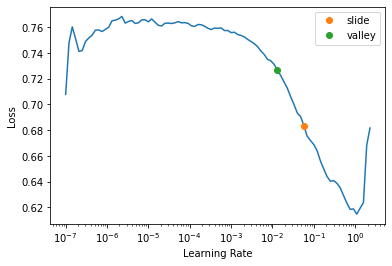

In [99]:
learn.lr_find(suggest_funcs=(slide, valley))

In [100]:
learn.fit(16, lr=0.04)

epoch,train_loss,valid_loss,accuracy,time
0,0.581938,0.564666,0.685393,00:00
1,0.516350,0.446952,0.820225,00:00
2,0.475446,0.447429,0.808989,00:00
3,0.446185,0.438210,0.808989,00:00
4,0.434582,0.440440,0.842697,00:00
5,0.421341,0.430151,0.814607,00:00
6,0.411949,0.414923,0.842697,00:00
7,0.404746,0.394601,0.837079,00:00
8,0.399333,0.406764,0.825843,00:00
9,0.393238,0.411465,0.825843,00:00


# Ensembling

In [106]:
tst_df = pd.read_csv(path/'test.csv')
tst_df['Fare'] = tst_df.Fare.fillna(0)
add_features(tst_df)

In [107]:
tst_dl = learn.dls.test_dl(tst_df)

In [108]:
def ensemble():
    learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])
    with learn.no_bar(),learn.no_logging(): learn.fit(16, lr=0.03)
    return learn.get_preds(dl=tst_dl)[0]

In [109]:
learns = [ensemble() for _ in range(5)]

In [110]:
ens_preds = torch.stack(learns).mean(0)

In [111]:
tst_df['Survived'] = (ens_preds[:,1]>0.5).int()
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('ens_sub.csv', index=False)

In [112]:
sub_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


# Random forest

In [9]:
np.set_printoptions(linewidth=130)

In [10]:
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle: path = Path('../input/titanic')
else:
    import zipfile,kaggle
    path = Path('titanic')
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

df = pd.read_csv(path/'train.csv')
tst_df = pd.read_csv(path/'test.csv')
modes = df.mode().iloc[0]

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [11]:
def proc_data(df):
    df['Fare'] = df.Fare.fillna(0)
    df.fillna(modes, inplace=True)
    df['LogFare'] = np.log1p(df['Fare'])
    df['Embarked'] = pd.Categorical(df.Embarked)
    df['Sex'] = pd.Categorical(df.Sex)

proc_data(df)
proc_data(tst_df)

In [12]:
cats=["Sex","Embarked"]
conts=['Age', 'SibSp', 'Parch', 'LogFare',"Pclass"]
dep="Survived"

In [13]:
df.Fare.head()

0     7.2500
1    71.2833
2     7.9250
3    53.1000
4     8.0500
Name: Fare, dtype: float64

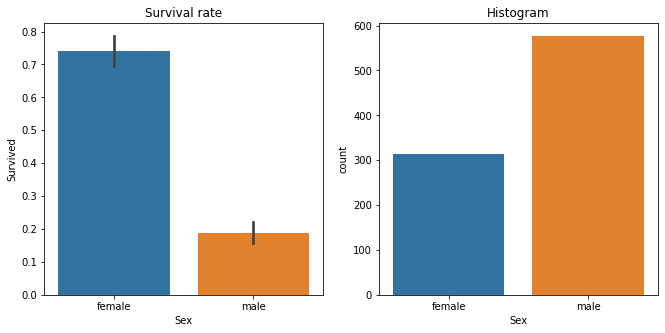

In [14]:
#binary splitting
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.barplot(data=df, y=dep, x="Sex", ax=axs[0]).set(title="Survival rate")
sns.countplot(data=df, x="Sex", ax=axs[1]).set(title="Histogram");

In [15]:
random.seed(42)
trn_df,val_df = train_test_split(df, test_size=0.25)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

In [16]:
def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

In [17]:
preds = val_xs.Sex==0

In [18]:
mean_absolute_error(val_y, preds)

0.21524663677130046

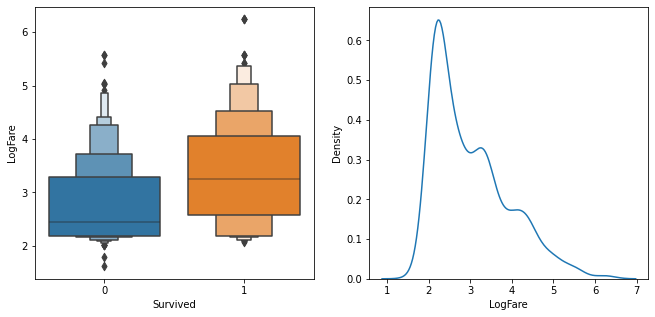

In [19]:
df_fare = trn_df[trn_df.LogFare>0]
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.boxenplot(data=df_fare, x=dep, y="LogFare", ax=axs[0])
sns.kdeplot(data=df_fare, x="LogFare", ax=axs[1]);

In [20]:
preds = val_xs.LogFare>2.7

In [21]:
mean_absolute_error(val_y, preds)

0.336322869955157

In [22]:
def _side_score(side, y):
    tot = side.sum()
    if tot<=1: return 0
    return y[side].std()*tot

In [23]:
def score(col, y, split):
    lhs = col<=split
    return (_side_score(lhs,y) + _side_score(~lhs,y))/len(y)

In [24]:
score(trn_xs["Sex"], trn_y, 0.5)

0.40787530982063946

In [25]:
score(trn_xs["LogFare"], trn_y, 2.7)

0.47180873952099694

In [26]:
def iscore(nm, split):
    col = trn_xs[nm]
    return score(col, trn_y, split)

interact(nm=conts, split=15.5)(iscore);

interactive(children=(Dropdown(description='nm', options=('Age', 'SibSp', 'Parch', 'LogFare', 'Pclass'), value…

In [27]:
nm = "Age"
col = trn_xs[nm]
unq = col.unique()
unq.sort()
unq

array([ 0.42,  0.67,  0.75,  0.83,  0.92,  1.  ,  2.  ,  3.  ,  4.  ,  5.  ,  6.  ,  7.  ,  8.  ,  9.  , 10.  , 11.  , 12.  ,
       13.  , 14.  , 14.5 , 15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 21.  , 22.  , 23.  , 24.  , 24.5 , 25.  , 26.  , 27.  ,
       28.  , 28.5 , 29.  , 30.  , 31.  , 32.  , 32.5 , 33.  , 34.  , 34.5 , 35.  , 36.  , 36.5 , 37.  , 38.  , 39.  , 40.  ,
       40.5 , 41.  , 42.  , 43.  , 44.  , 45.  , 45.5 , 46.  , 47.  , 48.  , 49.  , 50.  , 51.  , 52.  , 53.  , 54.  , 55.  ,
       55.5 , 56.  , 57.  , 58.  , 59.  , 60.  , 61.  , 62.  , 64.  , 65.  , 70.  , 70.5 , 74.  , 80.  ])

In [28]:
scores = np.array([score(col, trn_y, o) for o in unq if not np.isnan(o)])
unq[scores.argmin()]

6.0

In [29]:
def min_col(df, nm):
    col,y = df[nm],df[dep]
    unq = col.dropna().unique()
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx],scores[idx]

min_col(trn_df, "Age")

(6.0, 0.478316717508991)

In [30]:
cols = cats+conts
{o:min_col(trn_df, o) for o in cols}

{'Sex': (0, 0.40787530982063946),
 'Embarked': (0, 0.47883342573147836),
 'Age': (6.0, 0.478316717508991),
 'SibSp': (4, 0.4783740258817434),
 'Parch': (0, 0.4805296527841601),
 'LogFare': (2.4390808375825834, 0.4620823937736597),
 'Pclass': (2, 0.46048261885806596)}

In [31]:
cols.remove("Sex")
ismale = trn_df.Sex==1
males,females = trn_df[ismale],trn_df[~ismale]

In [32]:
{o:min_col(males, o) for o in cols}
{o:min_col(females, o) for o in cols}

{'Embarked': (0, 0.4295252982857327),
 'Age': (50.0, 0.4225927658431649),
 'SibSp': (4, 0.42319212059713535),
 'Parch': (3, 0.4193314500446158),
 'LogFare': (4.256321678298823, 0.41350598332911376),
 'Pclass': (2, 0.3335388911567601)}

In [33]:
m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y);

In [59]:
def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    #return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))
    return s

In [69]:
s=draw_tree(m, trn_xs, size=10)

In [83]:
source=s
print (source)
gvz=graphviz.Source(source)
# produce PDF
#gvz.view()
print (gvz.source)
display(gvz)

digraph Tree {
node [shape=box, style="filled, rounded", color="black", fontname="helvetica"] ;
edge [fontname="helvetica"] ;
0 [label=<Sex &le; 0.5<br/>gini = 0.47<br/>samples = 668<br/>value = [415, 253]>, fillcolor="#f5ceb2"] ;
1 [label=<Pclass &le; 2.5<br/>gini = 0.38<br/>samples = 229<br/>value = [59, 170]>, fillcolor="#7ebfee"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
3 [label=<gini = 0.06<br/>samples = 120<br/>value = [4, 116]>, fillcolor="#40a0e6"] ;
1 -> 3 ;
4 [label=<gini = 0.5<br/>samples = 109<br/>value = [55, 54]>, fillcolor="#fffdfb"] ;
1 -> 4 ;
2 [label=<Age &le; 6.5<br/>gini = 0.31<br/>samples = 439<br/>value = [356, 83]>, fillcolor="#eb9e67"] ;
0 -> 2 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
5 [label=<gini = 0.41<br/>samples = 21<br/>value = [6, 15]>, fillcolor="#88c4ef"] ;
2 -> 5 ;
6 [label=<gini = 0.27<br/>samples = 418<br/>value = [350, 68]>, fillcolor="#ea995f"] ;
2 -> 6 ;
}
digraph Tree {
node [shape=box, style="filled, round

ExecutableNotFound: failed to execute Path('dot'), make sure the Graphviz executables are on your systems' PATH

In [86]:
!pip3 install python-graphviz

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement python-graphviz (from versions: none)
ERROR: No matching distribution found for python-graphviz


In [63]:
from graphviz import Digraph

In [55]:
from graphviz import Graph, Source

In [68]:
from IPython.core.display import display, HTML

/tmp/ipykernel_428406/2058709175.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [87]:
!pip install https://gitlab.com/api/v4/projects/4207231/packages/generic/graphviz-releases/2.49.0/stable_windows_10_cmake_Release_x64_graphviz-install-2.49.0-win64.exe

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 4.7 MB 4.3 MB/s            
  ERROR: Cannot unpack file /tmp/pip-unpack-ssh8q098/stable_windows_10_cmake_Release_x64_graphviz-install-2.49.0-win64.exe (downloaded from /tmp/pip-req-build-r_0p85vi, content-type: application/octet-stream); cannot detect archive format
ERROR: Cannot determine archive format of /tmp/pip-req-build-r_0p85vi


In [91]:
!pip install https://www2.graphviz.org/Archive/stable/windows/graphviz-win-2.8.bin.tar.gz

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 5.2 MB 759 kB/s            
ERROR: File 'setup.py' not found for legacy project https://www2.graphviz.org/Archive/stable/windows/graphviz-win-2.8.bin.tar.gz.
